In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [11]:
df = pd.read_excel('./Online_Retail.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [12]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


### I. Data Preprocessing

In [13]:
df.isnull().sum(axis = 0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [14]:
df.shape

(541909, 8)

In [15]:
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df = df[df['CustomerID'].notnull()]

In [16]:
df.isnull().sum(axis = 0)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [17]:
df = df[df['Country'] == 'United Kingdom']

df.shape

(354321, 8)

### II. RFM 기반 Data Reengineering

- Recency : 가장 최근 상품 구매일에서 오늘까지의 기간
- Frequency : 상품 구매 횟수
- Monetary Value : 총 구매 금액

#### 1) sale_amount 추가

In [18]:
df['sale_amount'] = df['Quantity'] * df['UnitPrice']

#### 2) 주문 특성 확인

In [19]:
# top 5 주문 건수

df['CustomerID'] = df['CustomerID'].astype(int)

df['CustomerID'].value_counts().head(5)

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64

In [20]:
# top 5 주문 금액

df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending = False)[:5]

CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64

#### 3) CustomerID 기준으로 DF 재구성

In [21]:
aggregations = {'InvoiceDate' : 'max',
               'InvoiceNo' : 'count',
               'sale_amount' : 'sum'}

df_cid = df.groupby('CustomerID').agg(aggregations)

df_cid

,InvoiceDate,InvoiceNo,sale_amount
CustomerID,,,
12346,2011-01-18 10:01:00,1,77183.60
12747,2011-12-07 14:34:00,103,4196.01
12748,2011-12-09 12:20:00,4595,33719.73
12749,2011-12-06 09:56:00,199,4090.88
12820,2011-12-06 15:12:00,59,942.34
...,...,...,...
18280,2011-03-07 09:52:00,10,180.60
18281,2011-06-12 10:53:00,7,80.82
18282,2011-12-02 11:43:00,12,178.05


In [22]:
df_cid = df_cid.rename(columns = {'InvoiceDate' : 'Recency',
                                  'InvoiceNo' : 'Frequency',
                                  'sale_amount' : 'Monetary'})

df_cid = df_cid.reset_index()

In [23]:
df_cid

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73
3,12749,2011-12-06 09:56:00,199,4090.88
4,12820,2011-12-06 15:12:00,59,942.34
...,...,...,...,...
3915,18280,2011-03-07 09:52:00,10,180.60
3916,18281,2011-06-12 10:53:00,7,80.82
3917,18282,2011-12-02 11:43:00,12,178.05
3918,18283,2011-12-06 12:02:00,756,2094.88


#### 4) 최근 구매일자 Day로 변경

In [24]:
import datetime as dt

df_cid['Recency'] = dt.datetime(2011, 12, 10) - df_cid['Recency']
df_cid


,CustomerID,Recency,Frequency,Monetary
0,12346,325 days 13:59:00,1,77183.60
1,12747,2 days 09:26:00,103,4196.01
2,12748,0 days 11:40:00,4595,33719.73
3,12749,3 days 14:04:00,199,4090.88
4,12820,3 days 08:48:00,59,942.34
...,...,...,...,...
3915,18280,277 days 14:08:00,10,180.60
3916,18281,180 days 13:07:00,7,80.82
3917,18282,7 days 12:17:00,12,178.05
3918,18283,3 days 11:58:00,756,2094.88


In [25]:
df_cid['Recency'] = df_cid['Recency'].apply(lambda x: x.days + 1)
df_cid

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73
3,12749,4,199,4090.88
4,12820,4,59,942.34
...,...,...,...,...
3915,18280,278,10,180.60
3916,18281,181,7,80.82
3917,18282,8,12,178.05
3918,18283,4,756,2094.88


#### 5) Visualization

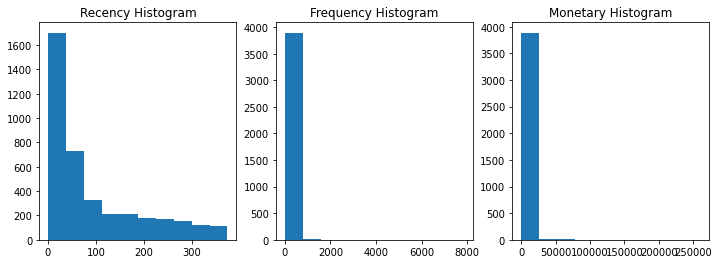

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 4),
                                    nrows = 1,
                                    ncols = 3)

ax1.set_title('Recency Histogram')
ax1.hist(df_cid['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(df_cid['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(df_cid['Monetary'])

plt.show()

## III. K-means Clustering

#### 1) Standardization

In [27]:
df_cid[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


In [28]:
from sklearn.preprocessing import StandardScaler

X_input = df_cid[['Recency', 'Frequency', 'Monetary']].values

X_input_scaled = StandardScaler().fit_transform(X_input)

In [29]:
X_input_scaled

array([[ 2.34381090e+00, -4.10449826e-01,  1.00669064e+01],
       [-9.01742172e-01,  5.79114471e-02,  3.11636875e-01],
       [-9.21838476e-01,  2.06841746e+01,  4.25767546e+00],
       ...,
       [-8.51501413e-01, -3.59940277e-01, -2.25389800e-01],
       [-8.91694020e-01,  3.05634195e+00,  3.08070865e-02],
       [-4.99816095e-01, -9.36172002e-02, -3.62284108e-03]])

#### 2) Modeling

In [30]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 5, random_state = 2045)

kmeans.fit_predict(X_input_scaled)

array([2, 0, 4, ..., 0, 2, 0])

#### 3) Silhouette Score

In [31]:
from sklearn.metrics import silhouette_score

silhouette_score(X_input_scaled, kmeans.fit_predict(X_input_scaled))

0.6167273481412517